<a href="https://colab.research.google.com/github/navseducation/sqltestwindowfunctions/blob/main/1_MNIST_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DCGAN  on MNIST

DCGAN is a Generative Adversarial Network (GAN) using CNN.

1. The discriminator learns to discriminate real from fake images.
2. The generator tries to fool the discriminator by generating fake images.
3. The generator + discriminator form an adversarial network.
4. DCGAN trains the discriminator and adversarial networks alternately.

During training, not only the discriminator learns to distinguish real from
fake images, it also coaches the generator part of the Adversarial network on how
to improve its ability to generate fake images.

In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import os

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
--- Starting GAN Training ---
Time for epoch 1 is 65.11 sec
Generator Loss: 0.7939, Discriminator Loss: 1.3938


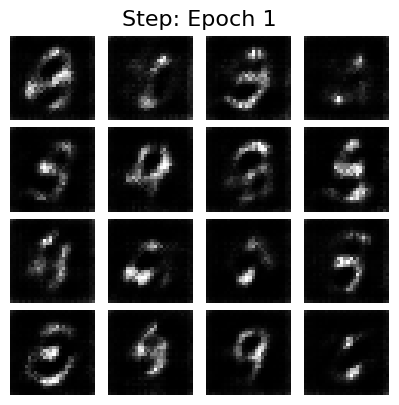

Time for epoch 2 is 60.03 sec
Generator Loss: 0.8178, Discriminator Loss: 1.4224


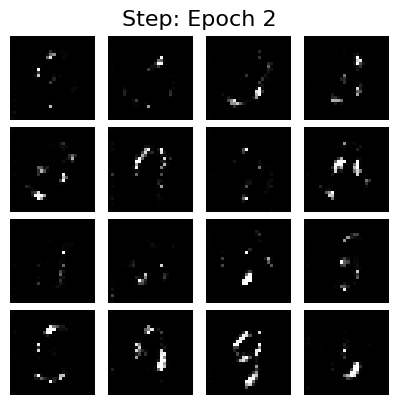

Time for epoch 3 is 59.86 sec
Generator Loss: 0.7671, Discriminator Loss: 1.3785


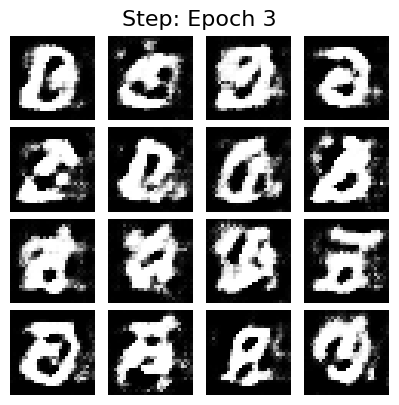

Time for epoch 4 is 60.57 sec
Generator Loss: 0.8277, Discriminator Loss: 1.3824


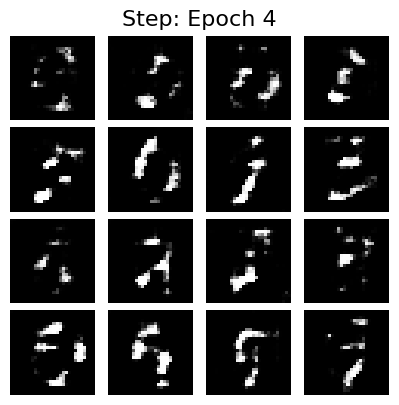

Time for epoch 5 is 61.71 sec
Generator Loss: 0.8261, Discriminator Loss: 1.3386


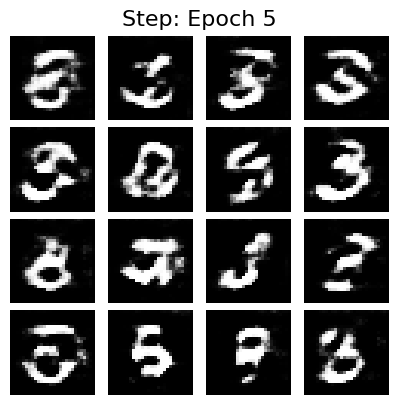

Time for epoch 6 is 60.42 sec
Generator Loss: 0.8982, Discriminator Loss: 1.3013


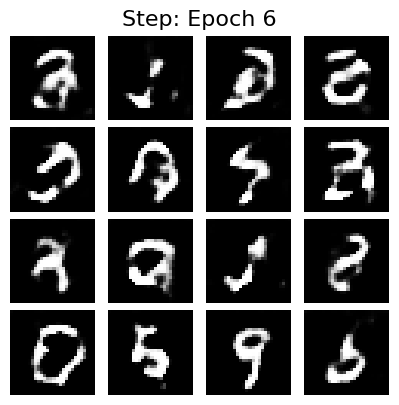

Time for epoch 7 is 60.46 sec
Generator Loss: 0.8767, Discriminator Loss: 1.2759


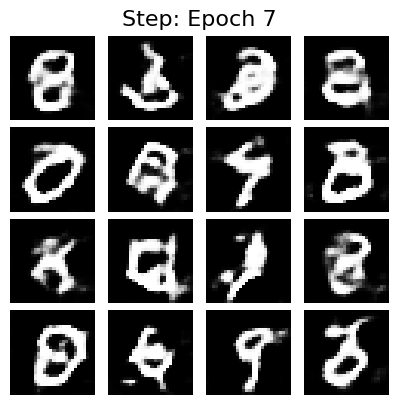

Time for epoch 8 is 59.80 sec
Generator Loss: 0.8800, Discriminator Loss: 1.3538


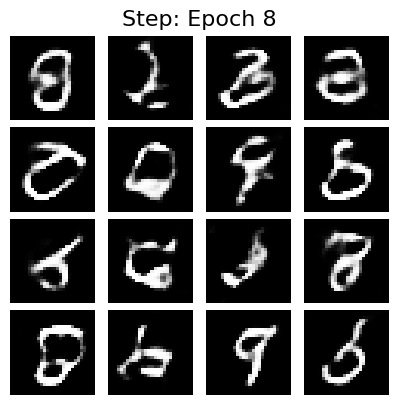

Time for epoch 9 is 60.16 sec
Generator Loss: 0.8869, Discriminator Loss: 1.3488


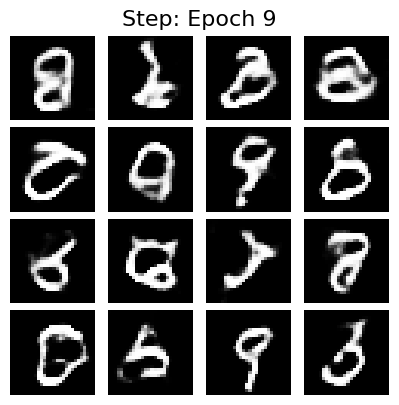

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# --- 1. Generator Model (Stable DCGAN Architecture) ---
# This model takes a random noise vector and upsamples it into a 28x28 image.
def build_generator(input_size=100):
    """Builds a stable Generator model based on the standard DCGAN architecture."""
    model = tf.keras.Sequential(name="Generator")
    model.add(tf.keras.layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(input_size,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    return model

# --- 2. Discriminator Model (Stable DCGAN Architecture) ---
# This model takes an image and outputs a single value indicating if it's real or fake.
def build_discriminator(data_shape=(28, 28, 1)):
    """Builds a stable Discriminator model."""
    model = tf.keras.Sequential(name="Discriminator")
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=data_shape))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    return model

# --- 3. Image Plotting Utility ---
# This helper function plots a grid of generated images.
def plot_images(model, test_input, step=None):
    """Generates and plots a grid of 16 images from the generator model."""
    predictions = model(test_input, training=False)
    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, 0] * 127.5 + 127.5), cmap='gray')
        plt.axis('off')
    if step is not None:
        plt.suptitle(f"Step: {step}", fontsize=16)
    plt.tight_layout(pad=0.5)
    plt.show()

# --- 4. Main Training Function (Using a Stable, Explicit Loop) ---
def train_gan(noise_size=100, epochs=50, batch_size=256):
    """The main training loop, using a stable and explicit GradientTape approach."""

    # --- Build Models and Optimizers ---
    generator = build_generator(noise_size)
    discriminator = build_discriminator()

    generator_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

    # --- Loss Functions ---
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def discriminator_loss(real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output) # Label smoothing
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def generator_loss(fake_output):
        return cross_entropy(tf.ones_like(fake_output), fake_output)

    # --- Load and Prepare Dataset ---
    (train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5

    # --- Training Loop ---
    seed = tf.random.normal([16, noise_size])

    print("--- Starting GAN Training ---")
    for epoch in range(epochs):
        start_time = time.time()

        # Shuffle the data at the start of each epoch
        np.random.shuffle(train_images)
        num_batches = train_images.shape[0] // batch_size

        for i in range(num_batches):
            # Get a batch of real images
            real_images = train_images[i*batch_size:(i+1)*batch_size]
            noise = tf.random.normal([batch_size, noise_size])

            # Use tf.GradientTape to record operations for automatic differentiation
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                generated_images = generator(noise, training=True)

                real_output = discriminator(real_images, training=True)
                fake_output = discriminator(generated_images, training=True)

                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            # Calculate and apply gradients to update the models
            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # At the end of each epoch, log progress and plot images
        print(f'Time for epoch {epoch + 1} is {time.time() - start_time:.2f} sec')
        print(f'Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}')
        plot_images(generator, seed, f"Epoch {epoch + 1}")

    print("\n--- Final Generated Images ---")
    plot_images(generator, seed, "Final")
    generator.save('mnist_generator_dcgan_final.h5')

# --- Main Execution Block ---
if __name__ == '__main__':
    # Simply call the main training function to run everything
    train_gan()
